# Assignment: Trees

## Do two questions in total: "Q1+Q2" or "Q1+Q3"

`! git clone https://github.com/ds3001f25/linear_models_assignment.git`

**Q1.** Please answer the following questions in your own words.
1. Why is the Gini a good loss function for categorical target variables?
2. Why do trees tend to overfit, and how can this tendency be constrained?
3. True or false, and explain: Trees only really perform well in situations with lots of categorical variables as features/covariates.
4. Why don't most versions of classification/regression tree concept allow for more than two branches after a split?
5. What are some heuristic ways you can examine a tree and decide whether it is probably over- or under-fitting?

Q1.1 Gini loss measures how often a randomly chosen sample would be incorrectly labeled if labeled according to class distribution. It is smooth, differentiable, and works well for categorical splits because it rewards pure nodes.

Q1.2 Overfitting occurs because trees keep splitting until every leaf is pure. It can be constrained by pruning, setting max depth, minimum samples per leaf, or using ensembles like Random Forests.

Q1.3 False. Trees can handle both categorical and continuous variables. They perform well with categorical variables but also work with numeric data when splits are chosen wisely.

Q1.4 Binary splits are two branches and are preferred because they simplify computation, make pruning easier, and yield more interpretable models; multiway splits can fragment data too much.

Q1.5 Check if the tree is too deep or has many small leaves (overfitting) or too shallow with high bias (underfitting). We can compare training versus validation accuracy, and a big gap means overfit.

**Q2.** This is a case study about classification and regression trees.

1. Load the `Breast Cancer METABRIC.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

2.  We'll use a consistent set of feature/explanatory variables. For numeric variables, we'll include `Tumor Size`, `Lymph nodes examined positive`, `Age at Diagnosis`. For categorical variables, we'll include `Tumor Stage`, `Chemotherapy`, and `Cancer Type Detailed`. One-hot-encode the categorical variables and concatenate them with the numeric variables into a feature/covariate matrix, $X$.

3. Let's predict `Overall Survival Status` given the features/covariates $X$. There are 528 missing values, unfortunately: Either drop those rows from your data or add them as a category to predict. Constrain the minimum samples per leaf to 10. Print a dendrogram of the tree. Print a confusion matrix of the algorithm's performance. What is the accuracy?

4. For your model in part three, compute three statistics:
    - The **true positive rate** or **sensitivity**:
        $$
        TPR = \dfrac{TP}{TP+FN}
        $$
    - The **true negative rate** or **specificity**:
        $$
        TNR = \dfrac{TN}{TN+FP}
        $$
    Does your model tend to perform better with respect to one of these metrics?

5. Let's predict `Overall Survival (Months)` given the features/covariates $X$. Use the train/test split to pick the optimal `min_samples_leaf` value that gives the highest $R^2$ on the test set (it's about 110). What is the $R^2$? Plot the test values against the predicted values. How do you feel about this model for clinical purposes?

In [1]:
# Q2.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# Load and basic info
df = pd.read_csv("/content/Breast Cancer METABRIC.csv")

print(f"Observations: {df.shape[0]} | Variables: {df.shape[1]}")
print(df.head(5))

Observations: 2509 | Variables: 34
  Patient ID  Age at Diagnosis Type of Breast Surgery    Cancer Type  \
0    MB-0000             75.65             Mastectomy  Breast Cancer   
1    MB-0002             43.19      Breast Conserving  Breast Cancer   
2    MB-0005             48.87             Mastectomy  Breast Cancer   
3    MB-0006             47.68             Mastectomy  Breast Cancer   
4    MB-0008             76.97             Mastectomy  Breast Cancer   

                        Cancer Type Detailed Cellularity Chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN           No   
1           Breast Invasive Ductal Carcinoma        High           No   
2           Breast Invasive Ductal Carcinoma        High          Yes   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate          Yes   
4  Breast Mixed Ductal and Lobular Carcinoma        High          Yes   

  Pam50 + Claudin-low subtype  Cohort ER status measured by IHC  ...  \
0                 cla

There are 2509 observations and 34 variables.

In [2]:
# Q2.2
numeric_features = ['Tumor Size', 'Lymph nodes examined positive', 'Age at Diagnosis']
categorical_features = ['Tumor Stage', 'Chemotherapy', 'Cancer Type Detailed']

# Check missing values and drop NAs
data = df[numeric_features + categorical_features]

print("Missing values per column:")
print(data.isnull().sum())

data = data.dropna()

# Encode categorical variables and display
data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)

X = data_encoded.copy()

print("\nFeature Matrix X Shape:", X.shape)
print("\nFirst few rows of X:")
print(X.head())

Missing values per column:
Tumor Size                       149
Lymph nodes examined positive    266
Age at Diagnosis                  11
Tumor Stage                      721
Chemotherapy                     529
Cancer Type Detailed               0
dtype: int64

Feature Matrix X Shape: (1400, 14)

First few rows of X:
   Tumor Size  Lymph nodes examined positive  Age at Diagnosis  \
0        22.0                           10.0             75.65   
1        10.0                            0.0             43.19   
2        15.0                            1.0             48.87   
3        25.0                            3.0             47.68   
4        40.0                            8.0             76.97   

   Tumor Stage_1.0  Tumor Stage_2.0  Tumor Stage_3.0  Tumor Stage_4.0  \
0            False             True            False            False   
1             True            False            False            False   
2            False             True            False            

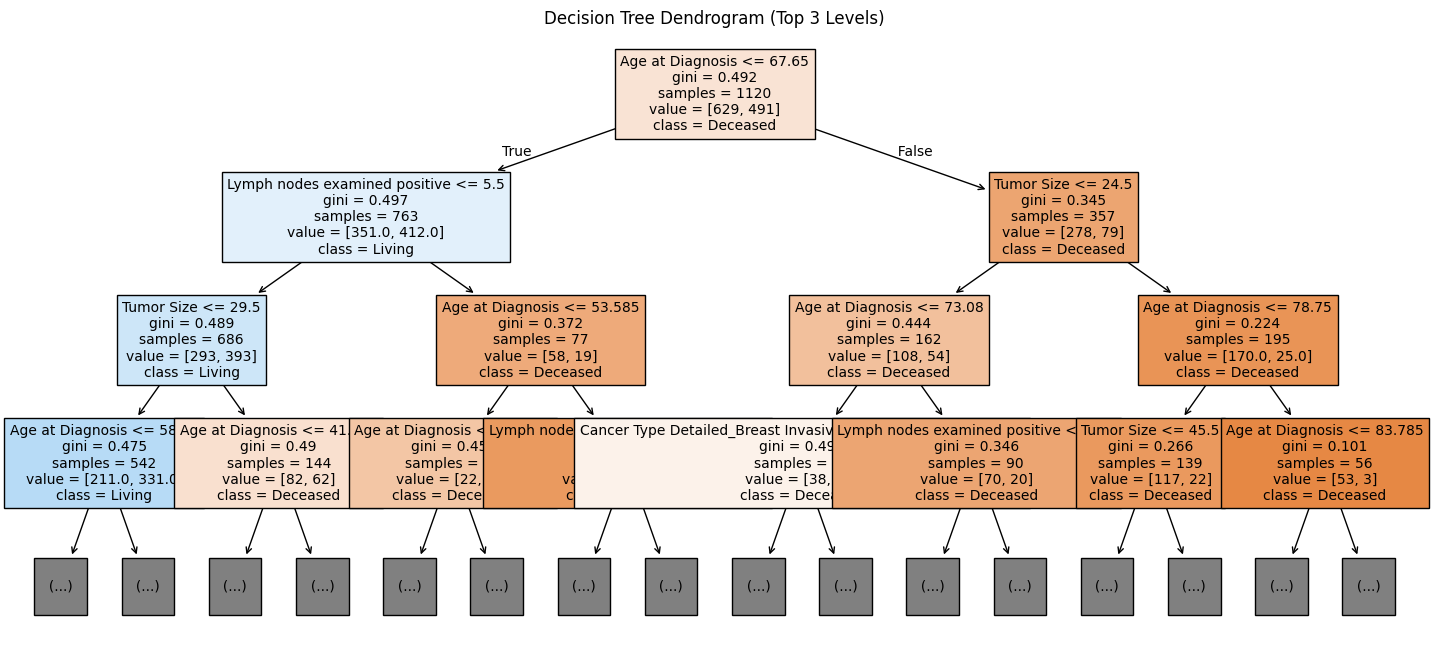


Confusion Matrix:
[[123  38]
 [ 49  70]]
Accuracy: 0.6893


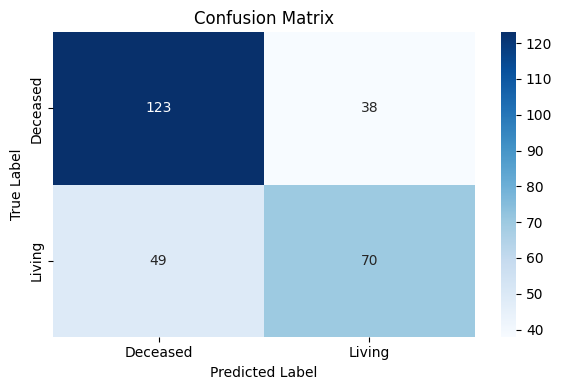

In [3]:
# Q2.3
# Train classification tree, keep only relevant columns and drop missing rows
full_data = df[numeric_features + categorical_features + ["Overall Survival Status"]].dropna()

# Encode categorical features
X = pd.get_dummies(full_data[numeric_features + categorical_features], drop_first=True)

# Target variable
y = full_data["Overall Survival Status"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit decision tree
tree_model = DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
tree_model.fit(X_train, y_train)

plt.figure(figsize=(18, 8))
plot_tree(
    tree_model,
    filled=True,
    feature_names=X.columns,
    class_names=tree_model.classes_,
    max_depth=3,
    fontsize=10
)
plt.title("Decision Tree Dendrogram (Top 3 Levels)")
plt.show()

# Evaluate model
y_pred = tree_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(conf_mat)
print(f"Accuracy: {acc:.4f}")

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_mat, annot=True, fmt="d", cmap="Blues",
    xticklabels=tree_model.classes_,
    yticklabels=tree_model.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

After dropping rows with missing values and training a decision tree classifier, the model achieved an accuracy of approximately 0.6893 (68.93%).

The confusion matrix shows that the model correctly predicted 123 deceased and 70 living patients, while misclassifying 38 deceased and 49 living cases. The model performs moderately well, slightly favoring correct classification of deceased patients over living ones.

In [4]:
# Q2.4
tn, fp, fn, tp = conf_mat.ravel()
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# Report metrics
print(f"True Positive Rate (TPR / Sensitivity): {tpr:.4f}")
print(f"True Negative Rate (TNR / Specificity): {tnr:.4f}")

# Single-line verdict
if tpr > tnr:
    print("\nThe model performs better in sensitivity (TPR is higher).")
elif tnr > tpr:
    print("\nThe model performs better in specificity (TNR is higher).")
else:
    print("\nThe model performs equally in sensitivity and specificity.")

True Positive Rate (TPR / Sensitivity): 0.5882
True Negative Rate (TNR / Specificity): 0.7640

The model performs better in specificity (TNR is higher).


The model’s true positive rate is 0.5882, and its true negative rate is 0.7640.

This indicates that the model performs better at correctly identifying patients who are actually deceased (higher specificity) than those who are living (lower sensitivity).

Best min_samples_leaf: 120
Best Test R²: 0.1346


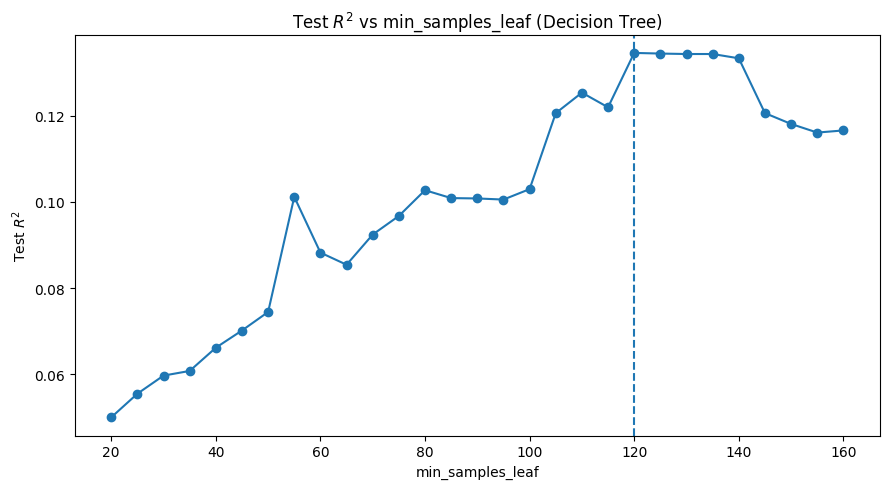

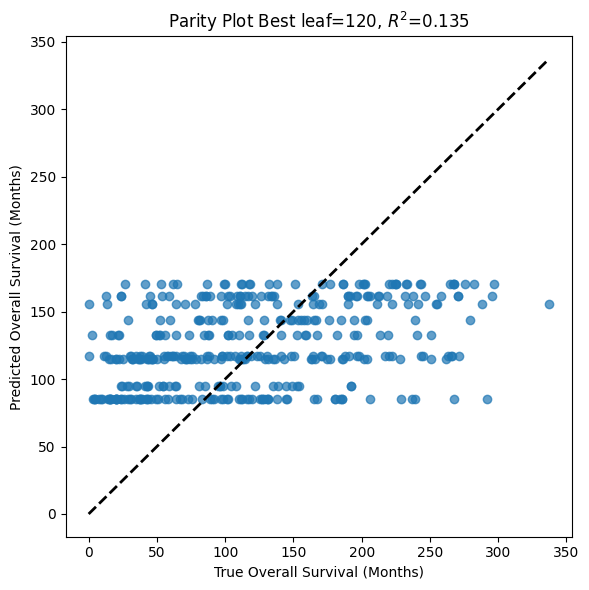

Clinical note: R² is low; tree alone is likely insufficient for clinical decisions.


In [6]:
# Q2.5
target = "Overall Survival (Months)"
# Keep rows with target present; leave feature NaNs to be imputed
df_reg = df[numeric_features + categorical_features + [target]].dropna(subset=[target])

X = df_reg[numeric_features + categorical_features].copy()
y = df_reg[target].astype(float)

# Preprocess median-impute numerics, mode-impute + one-hot cats
pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features),
        ("cat", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False))
        ]), categorical_features),
    ],
    remainder="drop"
)

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Sweep min_samples_leaf
leaf_grid = list(range(20, 161, 5))

def score_for_leaf(leaf):
    model = Pipeline([
        ("pre", pre),
        ("dt", DecisionTreeRegressor(min_samples_leaf=leaf, random_state=42))
    ])
    model.fit(X_tr, y_tr)
    yhat = model.predict(X_te)
    return r2_score(y_te, yhat)

scores = [(leaf, score_for_leaf(leaf)) for leaf in leaf_grid]
score_df = pd.DataFrame(scores, columns=["min_samples_leaf", "R2_test"])

best_idx = score_df["R2_test"].idxmax()
best_leaf = int(score_df.loc[best_idx, "min_samples_leaf"])
best_r2  = float(score_df.loc[best_idx, "R2_test"])

print(f"Best min_samples_leaf: {best_leaf}")
print(f"Best Test R²: {best_r2:.4f}")

# Refit at best leaf and parity plot
best_model = Pipeline([
    ("pre", pre),
    ("dt", DecisionTreeRegressor(min_samples_leaf=best_leaf, random_state=42))
])
best_model.fit(X_tr, y_tr)
yhat = best_model.predict(X_te)

plt.figure(figsize=(9, 5))
plt.plot(score_df["min_samples_leaf"], score_df["R2_test"], marker="o")
plt.axvline(best_leaf, linestyle="--")
plt.title("Test $R^2$ vs min_samples_leaf (Decision Tree)")
plt.xlabel("min_samples_leaf")
plt.ylabel("Test $R^2$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_te, yhat, alpha=0.7)
mn, mx = min(y_te.min(), yhat.min()), max(y_te.max(), yhat.max())
plt.plot([mn, mx], [mn, mx], "k--", lw=2)
plt.xlabel("True Overall Survival (Months)")
plt.ylabel("Predicted Overall Survival (Months)")
plt.title(f"Parity Plot Best leaf={best_leaf}, $R^2$={best_r2:.3f}")
plt.tight_layout()
plt.show()

if best_r2 < 0.3:
    print("Clinical note: R² is low; tree alone is likely insufficient for clinical decisions.")
elif best_r2 < 0.6:
    print("Clinical note: Moderate R²; might aid screening, but not stand-alone for decisions.")
else:
    print("Clinical note: Strong R² for a simple tree; still validate with calibration & external data.")

The optimal tree was found at min_samples_leaf = 120, with a best test R^2
=0.1346. The parity plot shows a weak correlation between predicted and true survival times, indicating that the model explains only a small portion of the variance. Clinically, this model is not reliable for decision-making, as its predictive accuracy is too low to support meaningful survival predictions.

**Q3.** This is a case study about trees using bond rating data. This is a dataset about bond ratings for different companies, alongside a bunch of business statistics and other data. Companies often have multiple reviews at different dates. We want to predict the bond rating (AAA, AA, A, BBB, BB, B, ..., C, D). Do business fundamentals predict the company's rating?

1. Load the `./data/corporate_ratings.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

2.  Plot a histogram of the `ratings` variable. It turns out that the gradations of AAA/AA/A and BBB/BB/B and so on make it hard to get good results with trees. Collapse all AAA/AA/A ratings into just A, and similarly for B and C.

3. Use all of the variables **except** Rating, Date, Name, Symbol, and Rating Agency Name. To include Sector, make a dummy/one-hot-encoded representation and include it in your features/covariates. Collect the relevant variables into a data matrix $X$.

4. Do a train/test split of the data and use a decision tree classifier to predict the bond rating. Including a min_samples_leaf constraint can raise the accuracy and speed up computation time. Print a confusion matrix and the accuracy of your model. How well do you predict the different bond ratings?

5. If you include the rating agency as a feature/covariate/predictor variable, do the results change? How do you interpret this?